# Part 5. Time series forecasting - exercise

> Try your best in one of the Monash datasets!

Today you'll apply the knowledge acquired in part 5 to perform forecasting on one 
of the datasets from the Monash time series forecasting archive (TSF). You don't 
have to build the TSC algorithm from scratch if you don't want to, but rather make
use of high level tools. Use the ones used in previous exercises such as:
- [aeon](https://github.com/aeon-toolkit/aeon)
- [tsai](https://github.com/timeseriesAI/tsai)
- [tslearn](https://github.com/tslearn-team/tslearn#available-features)
- [sk-time](https://github.com/sktime/sktime)

Or new ones seen in this course:
- [statsmodels](https://www.statsmodels.org/stable/index.html). Implements traditional
statistical forecasting models.
- [pytorch-forecasting](https://pytorch-forecasting.readthedocs.io/en/stable/): Pytorch
library built on top of [pytorch lightning](https://lightning.ai/docs/pytorch/stable/)
that implements several neural forecasting models including NHiTS. 

We are going to use the sunspot dataset. This dataset contains a single very long 
daily time series of sunspot numbers from 1818-01-08 to 2020-05-31. Be aware that
there is missing data. The nonmissing data version of this dataset was filled with
the LOCV method of imputation.

⚠️⚠️⚠️⚠️

* url_train = 'https://zenodo.org/api/records/4654773/files-archive'
* url_test = 'https://zenodo.org/api/records/4654722/files-archive'

⚠️⚠️⚠️⚠️

In [1]:
import datetime
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from aeon.datasets import load_from_tsf_file
from aeon.utils.windowing import sliding_windows
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error


In [2]:
missing_data, missing_metadata = load_from_tsf_file('data/sunspot_dataset_with_missing_values.tsf')
nonmissing_data, nonmissing_metadata = load_from_tsf_file('data/sunspot_dataset_without_missing_values.tsf')

print(missing_metadata)
print(nonmissing_metadata)
missing_data.head()

{'frequency': 'daily', 'forecast_horizon': None, 'contain_missing_values': True, 'contain_equal_length': True}
{'frequency': 'daily', 'forecast_horizon': None, 'contain_missing_values': False, 'contain_equal_length': True}


,series_name,start_timestamp,series_value
0,T1,1818-01-08,"[65.0, NaN, NaN, NaN, NaN, 37.0, NaN, NaN, NaN..."


## **Prepare train and test sets**

In [3]:
def to_dataframe(dataset: pd.DataFrame) -> pd.DataFrame:
    numeric_data = np.array(dataset.series_value[0])
    interval_date = datetime.timedelta(days=1) * (len(numeric_data) - 1)
    start_date = dataset.start_timestamp[0]
    date_index = pd.date_range(start_date, interval_date + start_date , freq='D')
    return pd.DataFrame(numeric_data, index=date_index, columns=['sunspot'])

In [4]:
training_data = to_dataframe(missing_data)[:datetime.datetime(2020, 1, 1)]
training_data["sunspot"] = training_data["sunspot"].astype(float)
filled_data = training_data.interpolate(method='linear', inplace=False)

# The nonmissing data starts from 2020, it is filled with LOCF, some errors are to be expected
TESTING_DATA = to_dataframe(nonmissing_data)[datetime.datetime(2020, 1, 1):]
TESTING_DATA.head(3)

,sunspot
2020-01-01,8.0
2020-01-02,13.0
2020-01-03,14.0


## **Visualize original and filled data**

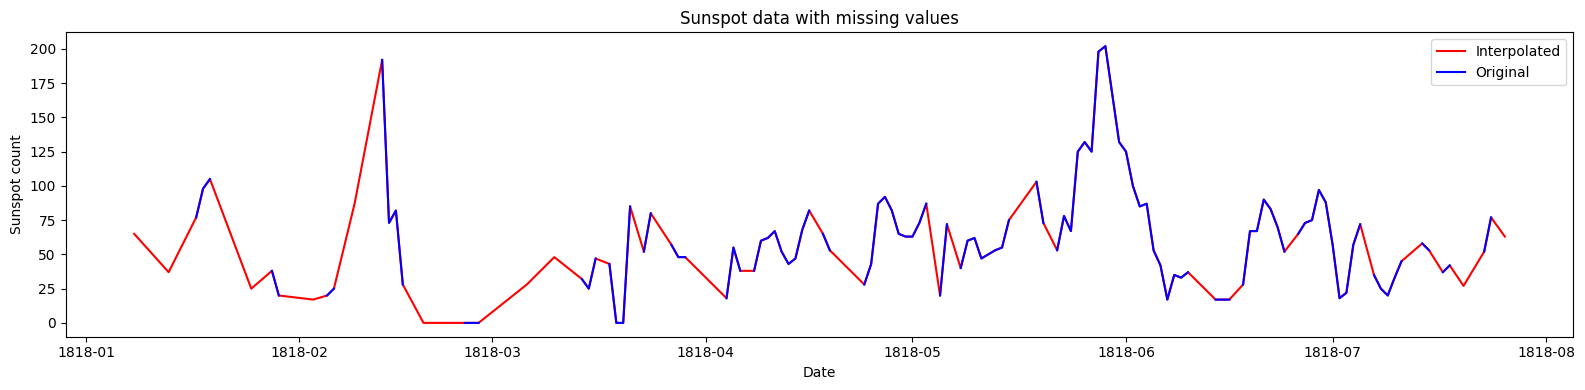

In [5]:
plt.figure(figsize=(16,4))
plt.plot(filled_data[:200], color='red', label='Interpolated')
plt.plot(training_data[:200], color='blue', label='Original')
plt.title('Sunspot data with missing values')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Sunspot count')
plt.tight_layout()
plt.show()

## **Aeon sliding window**

In [6]:
entire_df = pd.concat((filled_data, TESTING_DATA)).copy()
print(f"All data shape: {entire_df.shape}")
print(f"Testing data shape: {TESTING_DATA.shape}")

window_size = 120
all_windows, _ = sliding_windows(entire_df['sunspot'], window_size=window_size, stride=1)
y = [all_windows[i+1][-1] for i in range(len(all_windows)-1)]
all_windows = all_windows[:-1]

training_windows = all_windows[:len(filled_data)-window_size]
testing_windows = all_windows[len(filled_data)-window_size:]
y_train = y[:len(filled_data)-window_size]
y_test = y[len(filled_data)-window_size:]

print(f"***** {len(training_windows), len(y_train), len(testing_windows), len(y_test)} *****")

All data shape: (73925, 1)
Testing data shape: (152, 1)
***** (73653, 73653, 152, 152) *****


## **Base ARIMA model**

****** Tiempo entrenamiento base ARIMA: 0 minutos 5 segundos ******
Base ARIMA RMSE: 81.11915790933523


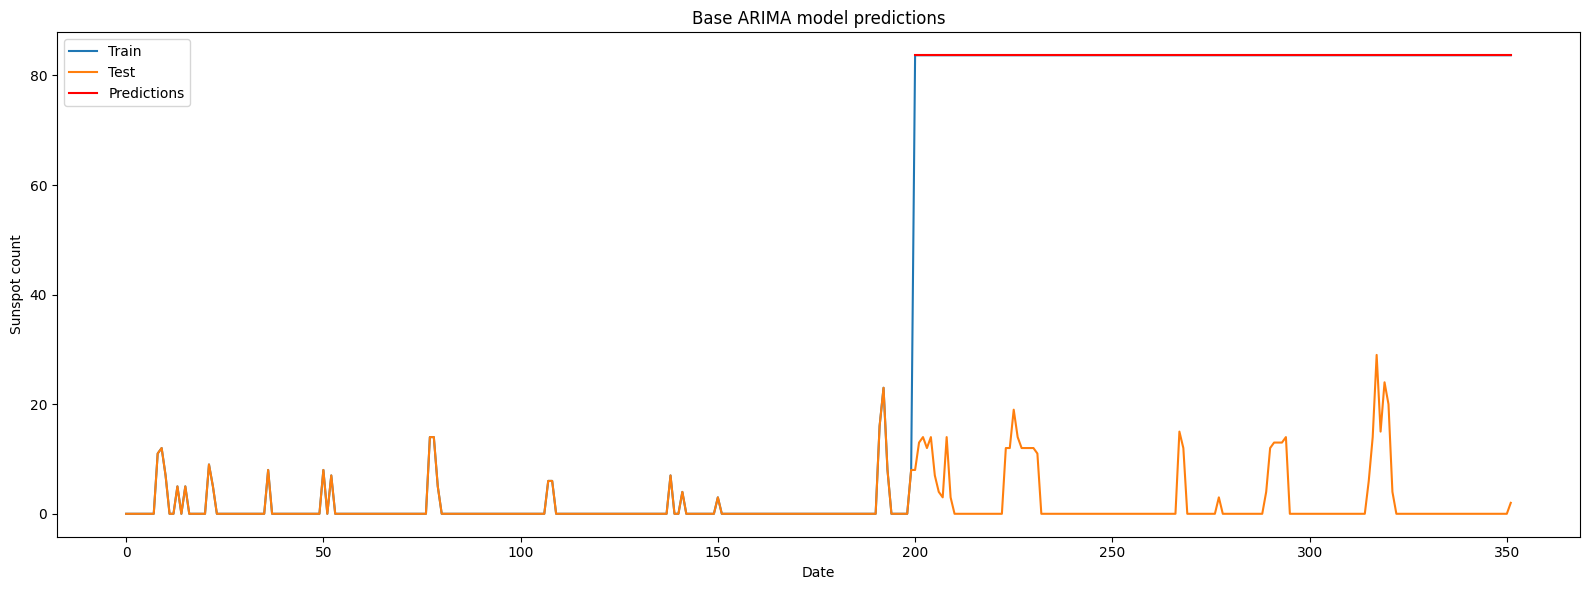

In [10]:
train_df = filled_data['sunspot']
test_df = TESTING_DATA['sunspot']

start = time.time()
model_arima = ARIMA(train_df, order=(0,0,0))
model_arima_fit = model_arima.fit()
predictions_arima = model_arima_fit.predict(start=len(train_df), end=len(train_df) + len(test_df) - 1)
train_and_pred = np.concatenate((train_df[-200:].to_numpy(), predictions_arima))
train_and_test = np.concatenate((train_df[-200:].to_numpy(), test_df.to_numpy()))

minutos, segundos = divmod(time.time() - start, 60)
print(f"****** Tiempo entrenamiento base ARIMA: {int(minutos)} minutos {int(segundos)} segundos ******")

rmse_arima = np.sqrt(mean_squared_error(train_and_test[-len(predictions_arima):], predictions_arima))
print(f"Base ARIMA RMSE: {rmse_arima}")

plt.figure(figsize=(16,6))
plt.plot(train_and_pred, label='Train')
plt.plot(train_and_test, label='Test')
plt.plot(range(len(train_and_pred)-len(predictions_arima), len(train_and_pred)), predictions_arima, color='red', label='Predictions')
plt.xlabel('Date')
plt.ylabel('Sunspot count')
plt.title('Base ARIMA model predictions')
plt.legend()
plt.tight_layout()
plt.show()

## **Modified SARIMAX model**

****** Tiempo entrenamiento SARIMAX: 1 minutos 18 segundos ******
SARIMAX RMSE: 6.202380883404458


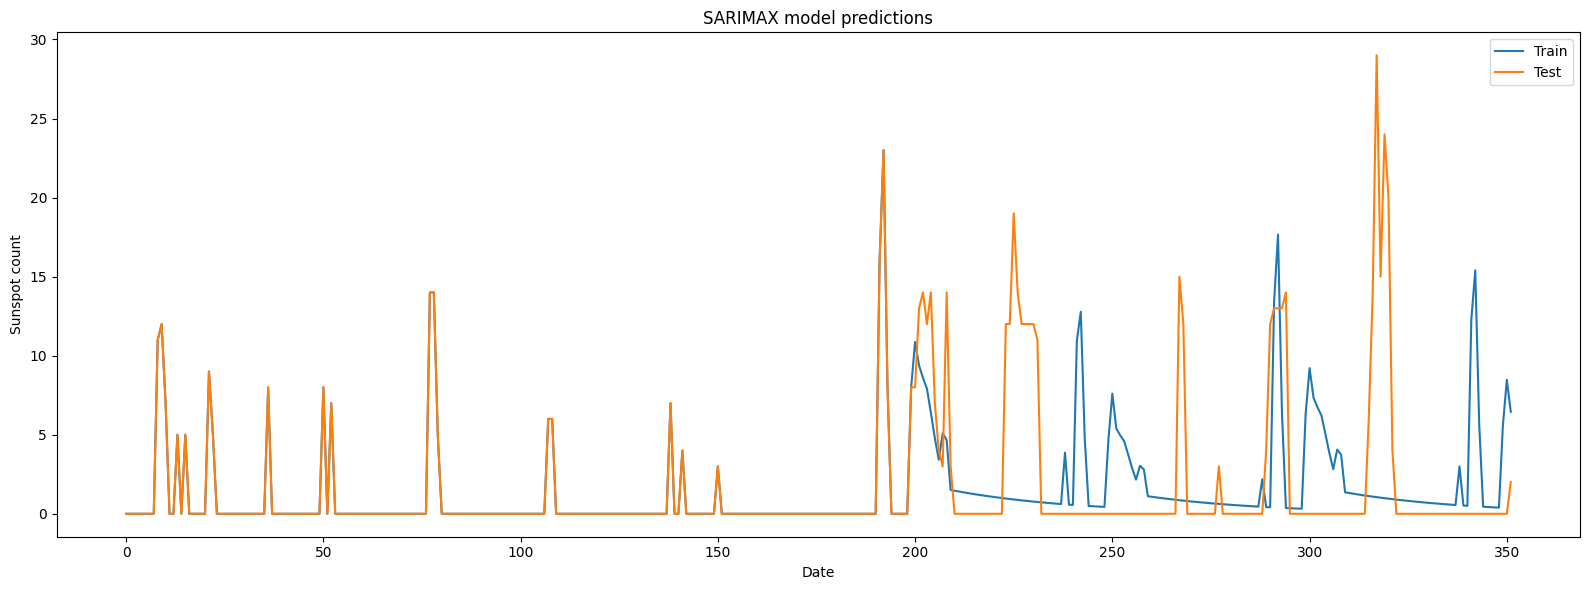

In [9]:
train_df = filled_data['sunspot'][-4000:] # last 4000 data points
test_df = TESTING_DATA['sunspot']

start = time.time()
model_arima = SARIMAX(train_df, order=(1, 0, 10), seasonal_order=(1, 1, 0, 50))
model_arima_fit = model_arima.fit()
predictions_arima = model_arima_fit.predict(start=len(train_df), end=len(train_df) + len(test_df) - 1)
train_and_pred = np.concatenate((train_df[-200:].to_numpy(), predictions_arima))
train_and_test = np.concatenate((train_df[-200:].to_numpy(), test_df.to_numpy()))

minutos, segundos = divmod(time.time() - start, 60)
print(f"****** Tiempo entrenamiento SARIMAX: {int(minutos)} minutos {int(segundos)} segundos ******")

rmse_sarimax = np.sqrt(mean_squared_error(train_and_test[-len(predictions_arima):], predictions_arima))
print(f"SARIMAX RMSE: {rmse_sarimax}")

plt.figure(figsize=(16,6))
plt.plot(train_and_pred, label='Train')
plt.plot(train_and_test, label='Test')
plt.xlabel('Date')
plt.ylabel('Sunspot count')
plt.title('SARIMAX model predictions')
plt.legend()
plt.tight_layout()
plt.show()

## **LSTM model**

In [ ]:
import torch
import torch.nn as nn
from tqdm.auto import tqdm
import random
from sklearn.metrics import mean_squared_error

# Define LSTM model
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size)
        self.linear = nn.Linear(hidden_layer_size, output_size)
        self.reset_hidden_cell()

    def reset_hidden_cell(self):
        self.hidden_cell = (torch.zeros(1,self.hidden_layer_size),
                            torch.zeros(1,self.hidden_layer_size))
        
    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq, self.hidden_cell)
        return self.linear(lstm_out)

# Prepare data for LSTM
train_data_normalized = torch.FloatTensor(training_windows)

# Initialize the model, define loss and optimization functions
model = LSTM(input_size=2, hidden_layer_size=50, output_size=2)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Train the model
epochs = 100
for i in range(epochs):
    epoch_loss = 0
    rmse = 0
    random.shuffle(train_inout_seq) # Randomize the training data
    for seq, labels in train_inout_seq:
        optimizer.zero_grad()
        model.reset_hidden_cell()
        y_pred = model(seq)

        single_loss = loss_function(y_pred.squeeze(), labels)
        single_loss.backward()
        optimizer.step()
        
        with torch.no_grad():
            epoch_loss += single_loss/len(train_inout_seq)
            rmse += np.sqrt(mean_squared_error(scaler.inverse_transform(labels.detach().numpy()), 
                                              scaler.inverse_transform(y_pred.squeeze().detach().numpy()))
                         )/len(train_inout_seq)

    print(f'Epoch {i} loss: {epoch_loss}. RMSE: {rmse}', end='\r')
    

/home/jaime/Escritorio/UPM/series temporales/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/tmp/ipykernel_62993/418801702.py:26: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:203.)
  train_data_normalized = torch.FloatTensor(training_windows)


NameError: name 'train_inout_seq' is not defined

# Task Definition

You have available a training and testing dataset. Both ``training_data`` and ``TESTING_DATA`` are not preprocessed, while training data should be preprocessed, the testing data is to never be modified in any way. The training data contains sunspot information up to (not including) 2020-01-1, while the testing data contains information from 2020-01-1 to 2020-05-31. Your task is to adequately forecast the 2020-05-31. You have to generate a forecast for each day of the testing time series. The objective metric to minimize is *RMSE*.

> Good luck!
 

## Your implementation